<a href="https://colab.research.google.com/github/LGuilhermeRodrigues/walk-recordings-filter/blob/main/walk_recordings_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar os dados

In [38]:
import pandas as pd

base_url = "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/"
files = [
    "20220914-102032.csv",
    "F1_50_df.csv",
    "knee_angles_corrigidoF1_42.csv",
    "knee_angles_corrigidoF1_57.csv",
    "knee_angles_corrigidoF2_00.csv",
    "knee_angles_corrigidoF2_12.csv"
]
files_filter = [
    35,
    35,
    42,
    52,
    30,
    33
]

unfiltered_dfs = [pd.read_csv(base_url + file) for file in files]
unfiltered_dfs = [df.reset_index().rename(columns={'index': 'row_id'}) for df in unfiltered_dfs]

Display the first few rows of the DataFrame to verify the data was loaded correctly.



In [39]:
unfiltered_dfs[0].head()

,row_id,time,Latitude,Longitude,shoulderLangle,shoulderRangle,shoulderLTransv,shoulderRTransv,elbowLangle,elbowRangle,...,l_kneeZ,r_kneeX,r_kneeY,r_kneeZ,l_ankleX,l_ankleY,l_ankleZ,r_ankleX,r_ankleY,r_ankleZ
0,0,102036,52.507613,13.390514,11,25,9,42,49,41,...,0.018,0.038,-0.404,-0.026,-0.190,-0.756,-0.070,0.007,-0.766,-0.133
1,1,102036,52.507613,13.390514,10,26,15,39,47,39,...,0.022,0.033,-0.404,-0.023,-0.189,-0.754,-0.063,-0.004,-0.769,-0.117
2,2,102036,52.507613,13.390514,10,26,15,38,47,39,...,0.024,0.032,-0.405,-0.023,-0.189,-0.751,-0.060,-0.007,-0.769,-0.116
3,3,102036,52.507613,13.390514,10,26,15,38,47,39,...,0.025,0.032,-0.405,-0.023,-0.189,-0.750,-0.059,-0.008,-0.770,-0.116
4,4,102036,52.507613,13.390514,10,27,17,38,48,39,...,0.025,0.032,-0.405,-0.023,-0.189,-0.750,-0.060,-0.008,-0.770,-0.117


### função de filtrar

In [40]:
good_blocks = []
bad_blocks = []

def filter_walking_blocks(df, time_col='time', columns_to_check=['kneeLangle', 'kneeRangle'], window_sec=5, threshold=50):
    global good_blocks
    global bad_blocks
    """
    Filters a DataFrame by keeping time blocks that contain specific activity.

    Args:
        df (pd.DataFrame): The input DataFrame.
        time_col (str): The name of the column with time in HHMMSS format.
        columns_to_check (list): A list of column names to check for the threshold.
        window_sec (int): The duration of each time block in seconds.
        threshold (float): The value that must be exceeded in the checked columns.

    Returns:
        pd.DataFrame: A new DataFrame containing only the valid blocks.
    """
    # Helper function to convert HHMMSS integer format to total seconds
    def time_to_seconds(t):
        t_int = int(t)
        hours = t_int // 10000
        minutes = (t_int % 10000) // 100
        seconds = t_int % 100
        return hours * 3600 + minutes * 60 + seconds

    # Work on a copy to avoid changing the original DataFrame
    data = df.copy()

    # 1. Create a new column with time converted to seconds
    data['time_seconds'] = data[time_col].apply(time_to_seconds)
    data = data.sort_values('time_seconds')

    # 2. Identify and collect all valid blocks
    valid_blocks = []
    min_time = data['time_seconds'].min()
    max_time = data['time_seconds'].max()

    # Iterate through the data in chunks of 'window_sec'
    for start_time in range(min_time, max_time, window_sec):
        end_time = start_time + window_sec

        # Get the current block of data
        block = data[(data['time_seconds'] >= start_time) & (data['time_seconds'] < end_time)]

        if block.empty:
            continue

        # Check if ANY value in ANY of the specified columns is > threshold
        if any((block[col] > threshold).any() for col in columns_to_check):
            valid_blocks.append(block)

        # Store the blocks for ML training
            good_blocks.append(block)
        else:
            bad_blocks.append(block)


    # 3. Combine valid blocks into a single DataFrame
    if not valid_blocks:
        print("No blocks were found meeting the criteria.")
        return pd.DataFrame(columns=df.columns) # Return empty DataFrame

    # Concatenate all valid blocks and drop the helper column
    result_df = pd.concat(valid_blocks).drop(columns=['time_seconds'])
    result_df = result_df.drop_duplicates().reset_index(drop=True)

    return result_df

### utilizando funcao de filtrar

In [41]:
good_blocks_train = []
bad_blocks_train = []
good_blocks_test = []
bad_blocks_test = []
filtered_dfs = []
for index, df in enumerate(unfiltered_dfs):
    # Get the correct threshold for the current file
    current_threshold = files_filter[index]

    # Apply the filtering function with the specific threshold
    filtered_df = filter_walking_blocks(df, threshold=current_threshold)

    # Reset the index for the new filtered dataframe and rename the new index column
    if not filtered_df.empty:
        filtered_df = filtered_df.reset_index(drop=True).reset_index().rename(columns={'index': 'new_row_id'})

    # Add the processed DataFrame to our list
    filtered_dfs.append(filtered_df)

    if index < 5:
        good_blocks_train.extend(good_blocks)
        bad_blocks_train.extend(bad_blocks)
    else:
        good_blocks_test.extend(good_blocks)
        bad_blocks_test.extend(bad_blocks)

    if index == 5:
        good_blocks = []
        bad_blocks = []

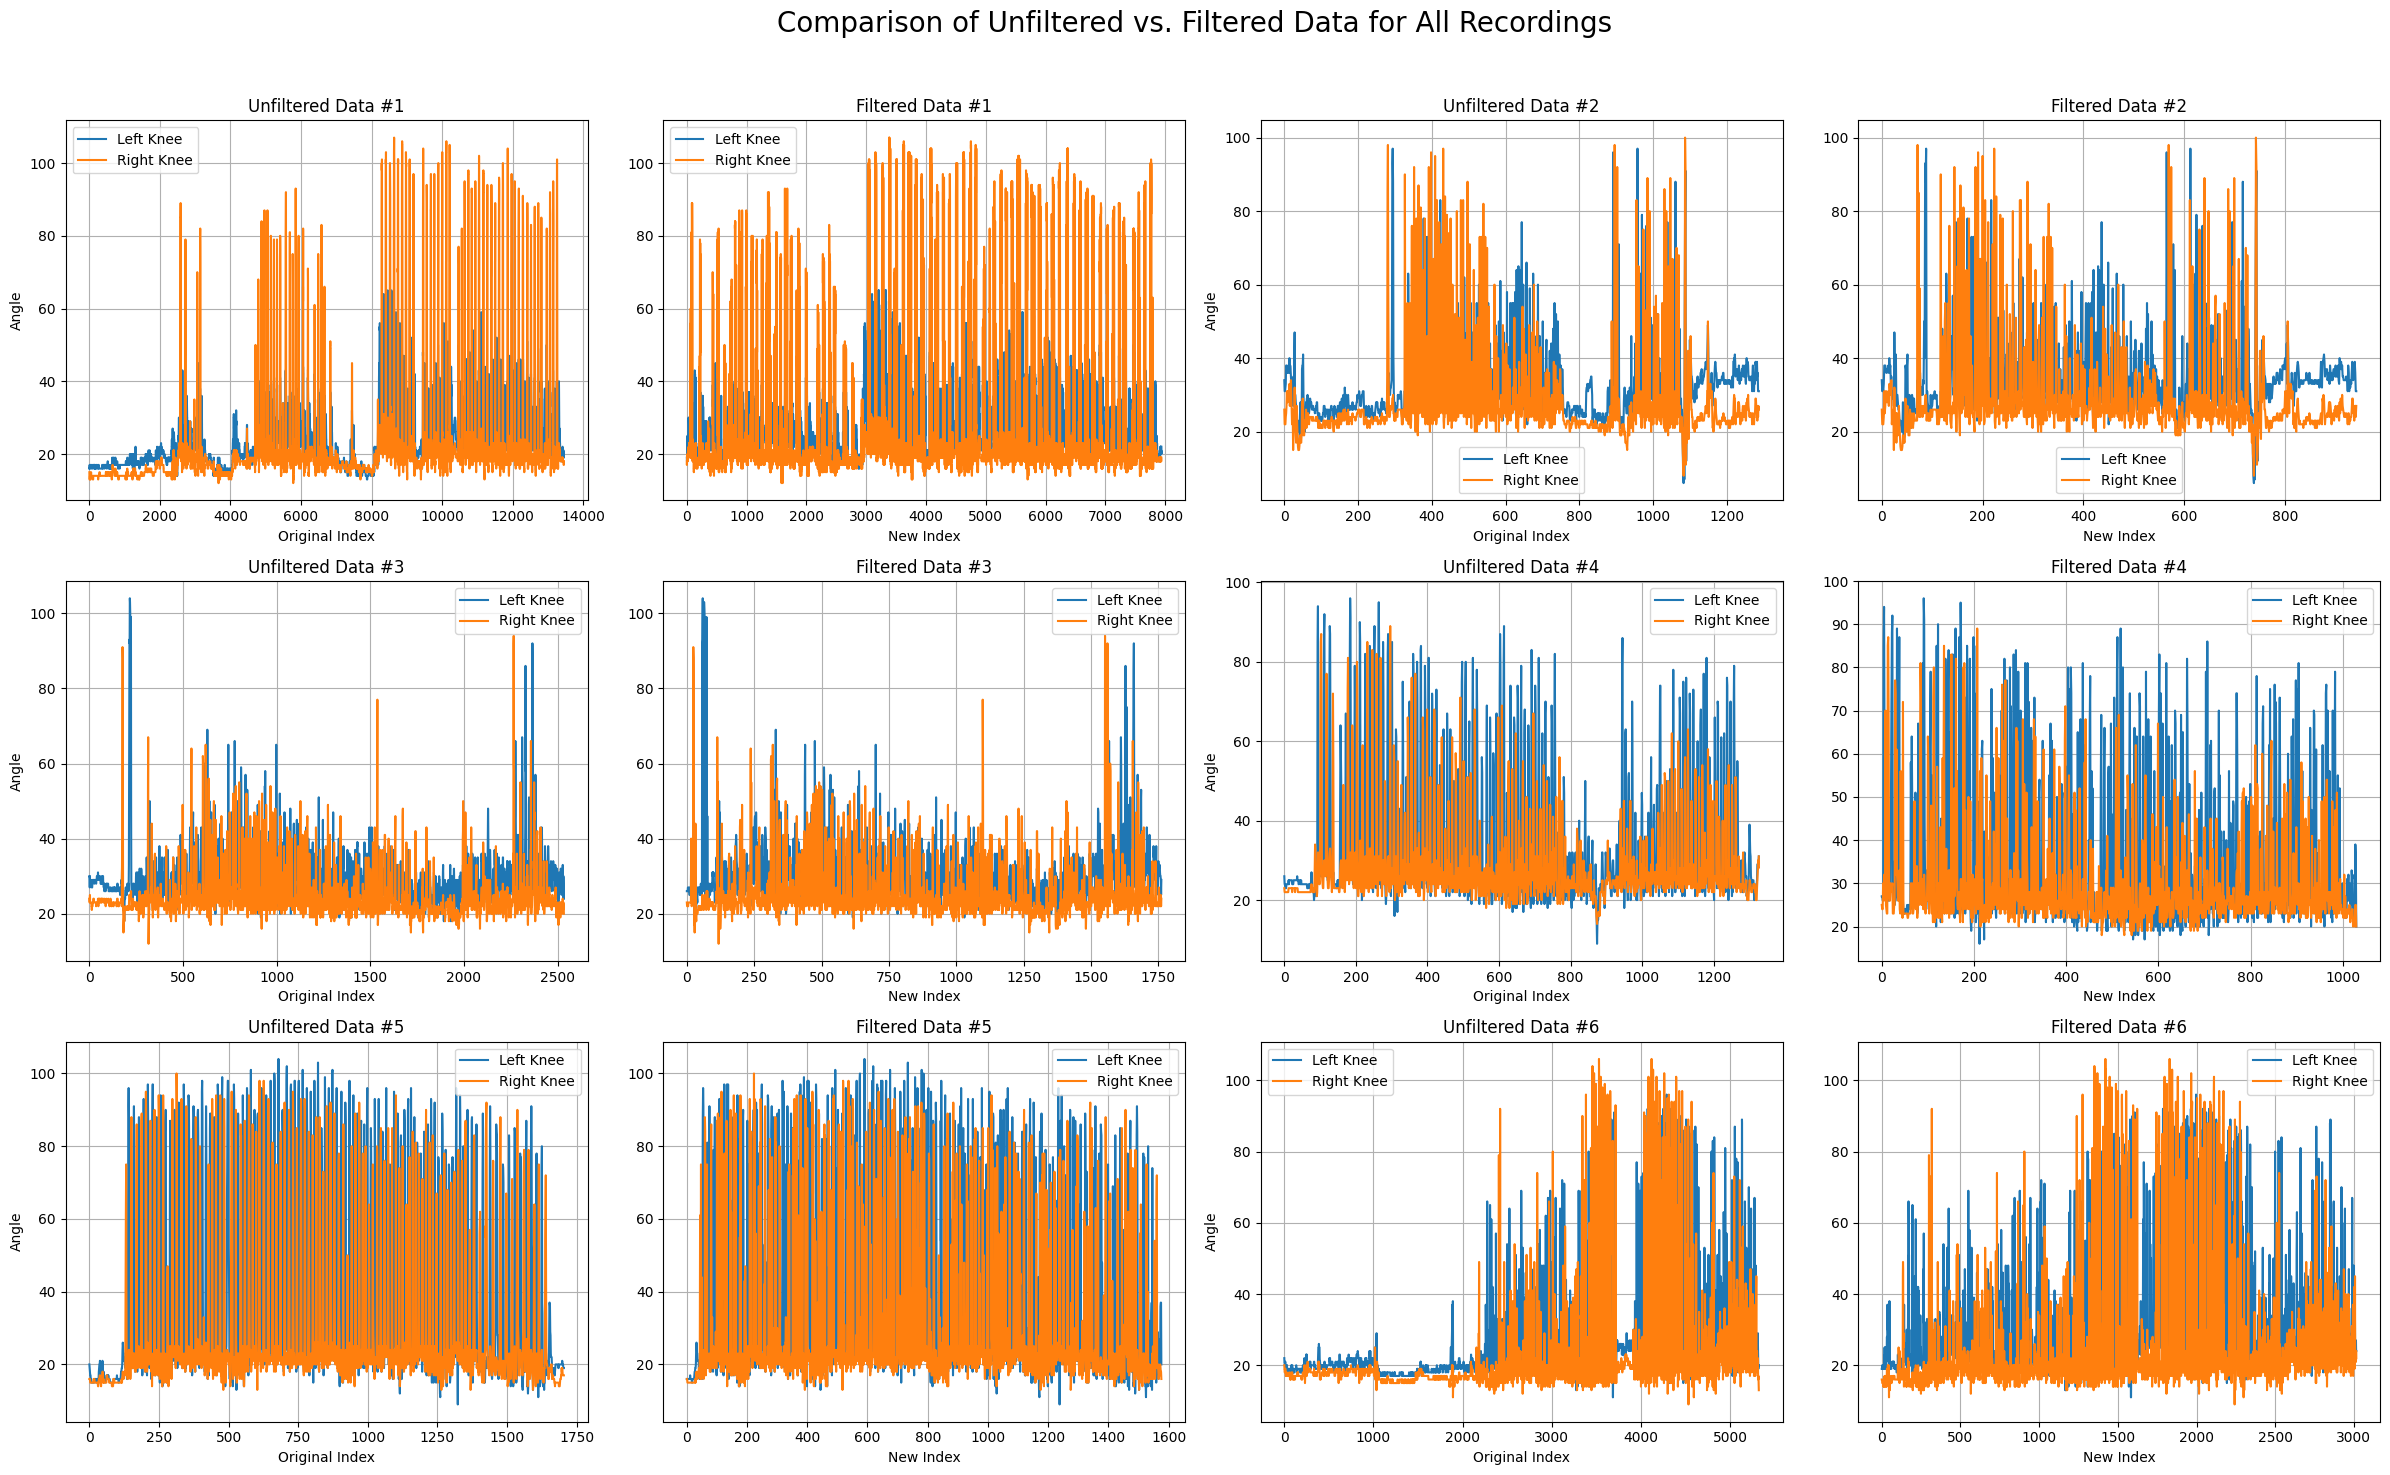

In [42]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with 3 rows and 4 columns
# The figsize is adjusted to accommodate the grid.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 15))

# Loop through all 6 files
for i in range(6):
    # Get the original and filtered data for the current file
    original_df = unfiltered_dfs[i]
    filtered_df = filtered_dfs[i]

    # Calculate the position in the grid
    row = i // 2
    col_orig = (i % 2) * 2
    col_filt = col_orig + 1

    # --- Plot Original Data ---
    ax_orig = axes[row, col_orig]
    ax_orig.plot(original_df['row_id'], original_df['kneeLangle'], label='Left Knee')
    ax_orig.plot(original_df['row_id'], original_df['kneeRangle'], label='Right Knee')
    ax_orig.set_title(f'Unfiltered Data #{i+1}')
    ax_orig.set_xlabel('Original Index')
    ax_orig.set_ylabel('Angle')
    ax_orig.legend()
    ax_orig.grid(True)

    # --- Plot Filtered Data ---
    ax_filt = axes[row, col_filt]
    # Check if the filtered DataFrame has any data to plot
    if not filtered_df.empty:
        ax_filt.plot(filtered_df['new_row_id'], filtered_df['kneeLangle'], label='Left Knee')
        ax_filt.plot(filtered_df['new_row_id'], filtered_df['kneeRangle'], label='Right Knee')
        ax_filt.set_title(f'Filtered Data #{i+1}')
        ax_filt.set_xlabel('New Index')
        ax_filt.legend()
    else:
        # If there's no data, just display a title
        ax_filt.set_title(f'Filtered Data #{i+1} (No valid blocks)')
        # Hide the axes ticks if the plot is empty
        ax_filt.set_xticks([])
        ax_filt.set_yticks([])

    ax_filt.grid(True)


# Add a main title for the entire figure
fig.suptitle('Comparison of Unfiltered vs. Filtered Data for All Recordings', fontsize=20)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [43]:
# input of the model will be 150 (5 seconds x 30fps) and a sample with less than
# size of 150 will have zeros at the end
bad_blocks_train[0].head(15)
# get knees values

knee_l_values = bad_blocks_train[0]['kneeLangle'].values
knee_r_values = bad_blocks_train[0]['kneeRangle'].values

print("Left Knee Angle Values:")
print(knee_l_values)
print("\nRight Knee Angle Values:")
print(knee_r_values)


Left Knee Angle Values:
[17 17 17 16 17 16 17 17 16 16 16 16 16 17 17 17 17 17 16 16 16 16 16 16
 16 17 17 17 16 16 17 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 16 16 16 16 16 16 17 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 17 16 17 17 17 16 16 16 17 17 17 17
 17 17 17 17 17 17 16]

Right Knee Angle Values:
[13 13 13 13 13 13 13 13 13 13 15 13 14 13 13 13 14 13 14 14 14 14 14 14
 14 14 14 14 14 14 13 13 14 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 15 15 14 14 15 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13 14 14 14 14 13 14 14
 13 13 13 13 14 14 14]


In [45]:
import pandas as pd
import numpy as np

def standardize_and_concat_knees(block_df, target_size_per_limb=150):
    """
    Takes a block, standardizes the left and right knee angle columns
    to a fixed size, and concatenates them into a single feature vector.

    Args:
        block_df (pd.DataFrame): The input data block.
        target_size_per_limb (int): The desired size for each limb's data (e.g., 150).

    Returns:
        np.ndarray: A single NumPy array of size 300.
    """
    # Helper function to pad (with zeros) or truncate a single data array
    def pad_or_truncate(arr, target_size):
        current_len = len(arr)
        if current_len >= target_size:
            # Truncate if the array is too long
            return arr[:target_size]
        else:
            # Pad with zeros if the array is too short
            padding_needed = target_size - current_len
            return np.pad(arr, (0, padding_needed), mode='constant', constant_values=0)

    # 1. Process Left Knee
    knee_l_values = block_df['kneeLangle'].values
    knee_l_standardized = pad_or_truncate(knee_l_values, target_size_per_limb)

    # 2. Process Right Knee
    knee_r_values = block_df['kneeRangle'].values
    knee_r_standardized = pad_or_truncate(knee_r_values, target_size_per_limb)

    # 3. Concatenate the two arrays into a single feature vector
    final_vector = np.concatenate([knee_l_standardized, knee_r_standardized])

    return final_vector


knee_values = standardize_and_concat_knees(bad_blocks_train[0], target_size_per_limb=150)
print(knee_values)
print(len(knee_values))

[17 17 17 16 17 16 17 17 16 16 16 16 16 17 17 17 17 17 16 16 16 16 16 16
 16 17 17 17 16 16 17 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 16 16 16 16 16 16 17 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 17 16 17 17 17 16 16 16 17 17 17 17
 17 17 17 17 17 17 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 13 13 13 13 13 13 13 13 13 13 15 13 14 13 13 13 14 13
 14 14 14 14 14 14 14 14 14 14 14 14 13 13 14 13 13 13 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 15 15 14 14 15 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13 14
 14 14 14 13 14 14 13 13 13 13 14 14 14  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
300


In [46]:
X_train_good = []
X_train_bad = []
X_test_good = []
X_test_bad = []

for block in good_blocks_train:
    X_train_good.append(standardize_and_concat_knees(block, target_size_per_limb=150))
for block in bad_blocks_train:
    X_train_bad.append(standardize_and_concat_knees(block, target_size_per_limb=150))
for block in good_blocks_test:
    X_test_good.append(standardize_and_concat_knees(block, target_size_per_limb=150))
for block in bad_blocks_test:
    X_test_bad.append(standardize_and_concat_knees(block, target_size_per_limb=150))

# sizes:
print(len(X_train_good))
print(len(X_train_bad))
print(len(X_test_good))
print(len(X_test_bad))

737
367
287
123


Final X_train shape: (1104, 300)
Final y_train shape: (1104,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6863 - loss: 0.5439 - val_accuracy: 0.8927 - val_loss: 0.3036
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8572 - loss: 0.3042 - val_accuracy: 0.8780 - val_loss: 0.2428
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9184 - loss: 0.1869 - val_accuracy: 0.8951 - val_loss: 0.2277
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9334 - loss: 0.1736 - val_accuracy: 0.9000 - val_loss: 0.2195
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9419 - loss: 0.1266 - val_accuracy: 0.9000 - val_loss: 0.2169
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9704 - loss: 0.0918 - val_accuracy: 0.9024 - val_loss: 0.2505
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9565 - loss: 0.0904 - val_accuracy: 0.9049 - val_loss: 0.2788
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9812 - loss: 0.0623 

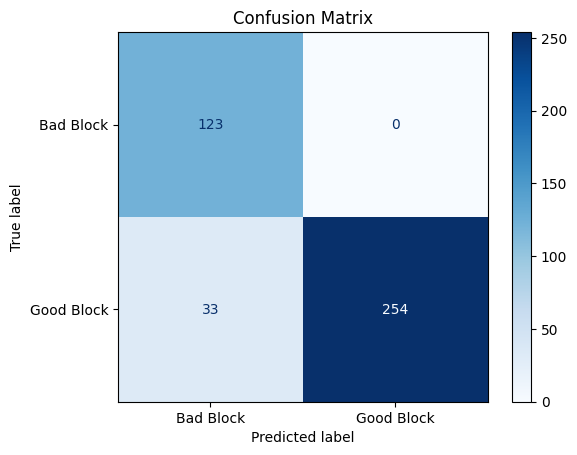

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# --- 1. Combine and Prepare the Final Datasets ---

# Combine the good and bad blocks for the training set
X_train = np.array(X_train_good + X_train_bad)
# Create labels: 1 for 'good', 0 for 'bad'
y_train = np.array([1] * len(X_train_good) + [0] * len(X_train_bad))

# Combine for the testing set
X_test = np.array(X_test_good + X_test_bad)
y_test = np.array([1] * len(X_test_good) + [0] * len(X_test_bad))

# Shuffle the training data to ensure the model sees both classes in each batch
X_train, y_train = shuffle(X_train, y_train, random_state=42)
# Shuffling the test set is not strictly necessary but is good practice
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final y_train shape: {y_train.shape}")


# --- 2. Scale the Data ---
# It's crucial to scale the data for neural networks to perform well.
scaler = StandardScaler()
# Fit the scaler ONLY on the training data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


# --- 3. Build the Keras Model ---
# This model is designed for your input shape of (300,)
model = keras.Sequential([
    # Input layer specifies the shape of your feature vector (300)
    layers.Input(shape=(300,)),
    # First dense layer with 128 neurons
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4), # Dropout helps prevent overfitting
    # Second dense layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    # Third dense layer
    layers.Dense(64, activation='relu'),
    # Output layer: 1 neuron with a sigmoid activation for binary (0 or 1) output
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with an optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


# --- 4. Train the Model ---
print("\n--- Starting Model Training ---")
history = model.fit(X_train_scaled, y_train,
                    epochs=50,  # You can adjust the number of epochs
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    verbose=1)


# --- 5. Evaluate and Visualize Results ---
print("\n--- Evaluating Model Performance ---")
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

# Generate predictions to create the confusion matrix
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad Block", "Good Block"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()